In [1]:
import numpy as np
import pandas as pd
# added the two lines below
import nltk
#ntlk.download('stopwords')
#nltk.download('punkt')
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
%matplotlib inline

## Load and clean the data

In [2]:
df = pd.read_csv('C:\\Users\\mschul3\\Documents\\WatsonCI\\tweets_labelled.csv')

# select the attack and text columns
df = df[['attack', 'text']]

# drop rows with nan values
df = df.dropna()

# drop any with all white-space text
df.text = df.text.str.strip()
df = df[df.text!='']

# convert the attack column to an integer
df.attack = df.attack.astype('int')

## Look at the data

In [3]:
df.head()

,attack,text
0,0,Today I introduced the Addressing Teacher Shor...
1,1,Wholeheartedly agree .@RepJeffries -- McConnel...
2,0,Look forward to reading it. Thanks!
3,0,"When we passed the Tax Cuts and Jobs Act, it h..."
4,1,There's still time for an @FBI background inve...


In [4]:
# look at number of attacks.
# 0: not attack
# 1: attack
df.groupby('attack').count()

,text
attack,
0,1110
1,165


Note that there are many more _non-attacks_ than _attacks_. This is called class imbalance and can lead to challenges for modeling and model evaluation.

In [5]:
# show ten random tweets
list(df.sample(10, replace=False).text)

["This week's Insta-Poll: No Budget, No Pay http://lance.congressnewsletter.net/common/mailings/index.cfm?sniv=2100098576.56087.96.2...",
 'I sat in on interviews w/students pursuing a nomination to a US service academy. I was impressed by their patriotism & commitment #PA11#NEPA',
 'Turn on @FoxBusiness at 11am Central to watch me on Cavuto!',
 'Consumer confidence has reached the highest level since December 2000! Our economy is growing stronger!https://goo.gl/m7qiAw',
 'On Wednesday, Zuckerberg will testify before @HouseCommerce. I look forward to questioning him.',
 'Honoring the memory of those we lost 15 years ago today at the #Yonkers 9/11 memorial ceremony #NeverForgetpic.twitter.com/txZzaoDx1h',
 'David and Ashley are true heroes. The epitome of bravery.',
 'This court ruling is an important victory. The implementation of #Obamacare was illegal and its policies are harmful. http://thehill.com/policy/healthcare/253115-court-allows-boehner-lawsuit-against-obamacare-to-move-forwa

## Preprocess text
Preprocessing is one of the subtlest parts of natural language processing. For brevity, we perform only the most basic steps. 

In [6]:
# replace all punctuation with space
def remove_punctuation(txt):
    #txt = txt.translate(None, string.punctuation)
    txt = txt.translate(str.maketrans('','',string.punctuation))
    
    return txt

# lowercase text
def lowercase(txt):
    txt = txt.lower()
    # TODO: more nuanced rules...
    return txt

# remove stopwords
def remove_stopwords(txt):
    stop_words = set(stopwords.words('english')) 
    toks = word_tokenize(txt) 
    toks = [w for w in toks if not w in stop_words]
    txt = " ".join(toks)
    
    return txt

# TODO: perform other steps...

# put all steps together
def preproc(txt):
    txt = remove_punctuation(txt)
    txt = lowercase(txt)
    txt = remove_stopwords(txt)
    #TODO: other steps...
    
    return txt    

In [7]:
# try it out on some text
preproc("why are the lights sooooo bright")

'lights sooooo bright'

In [8]:
# Apply the preprocessing to our text
df['text_proc'] = df.text.apply(lambda txt: preproc(txt))

In [9]:
# Take a look at the processed txt
df.sample(20, replace=False)[['text', 'text_proc']]

,text,text_proc
849,Philip Seymour Hoffman was a national treasure...,philip seymour hoffman national treasure roc s...
253,"TUNE IN: At 4:35 p.m. CT, I'm joining @KeithSh...",tune 435 pm ct im joining keithsherley live 10...
917,Happy Mother's Day!,happy mothers day
840,Pleasure interviewing w/ @kktv11news DC report...,pleasure interviewing w kktv11news dc reporter...
1194,Sign up for Mac's eNewsletter today: https://t...,sign macs enewsletter today httpsthornberryfor...
750,We must support long-term solutions w/ shovel-...,must support longterm solutions w shovelready ...
154,Let's go wildcats #EMAW #MarchMadness2018@KSta...,lets go wildcats emaw marchmadness2018kstatembb
454,Will be live soon w/ @wolfblitzer on @CNNSitRo...,live soon w wolfblitzer cnnsitroom discuss cal...
1128,#FiscalCliff includes a hike in the Estate Tax...,fiscalcliff includes hike estate tax 35 55 hel...
455,Our #privacy rights must be protected. Corpora...,privacy rights must protected corporations sho...


## Bag of words model

In [10]:
# select data for modeling
y = df['attack']
X = df['text_proc'] 
X.shape

(1275,)

In [11]:
# get count features
count_vect = CountVectorizer(
    ngram_range=(1,2),
    strip_accents='unicode',
    min_df = 5 # min document frequency; every unigram/bigram repeated less than 5 times is discarded
    )
X_counts = count_vect.fit_transform(X)
X_counts.shape # shape gives us dimensions of an array

(1275, 609)

In [12]:
# hold-out some data for final validation - don't need to worry about this right now
X_counts_train, X_counts_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.25, random_state=42)

In [13]:
# Define and fit the model
estimator =  LogisticRegression()
params = dict(C=[10,3,1,0.3,0.1])
clf_cv = GridSearchCV(estimator, param_grid=params, cv=8, verbose=5, n_jobs=6, return_train_score=True)
print(clf_cv.fit(X_counts_train, y_train))

Fitting 8 folds for each of 5 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   10.5s
[Parallel(n_jobs=6)]: Done  38 out of  40 | elapsed:   10.7s remaining:    0.5s


GridSearchCV(cv=8, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'C': [10, 3, 1, 0.3, 0.1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=5)


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:   10.8s finished
C:\Users\mschul3\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
# raw cross-validation results
res = clf_cv.cv_results_
res

{'mean_fit_time': array([0.0158709 , 0.01444602, 0.00644806, 0.0052695 , 0.00440201]),
 'std_fit_time': array([0.00749226, 0.00971381, 0.0020892 , 0.00235186, 0.00029731]),
 'mean_score_time': array([0.0009293 , 0.00179794, 0.0017983 , 0.00049654, 0.00061977]),
 'std_score_time': array([3.86123356e-04, 2.36494553e-03, 2.36515490e-03, 3.94247668e-07,
        2.14599701e-04]),
 'param_C': masked_array(data=[10, 3, 1, 0.3, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10}, {'C': 3}, {'C': 1}, {'C': 0.3}, {'C': 0.1}],
 'split0_test_score': array([0.81818182, 0.85123967, 0.85950413, 0.87603306, 0.8677686 ]),
 'split1_test_score': array([0.86666667, 0.875     , 0.89166667, 0.88333333, 0.875     ]),
 'split2_test_score': array([0.9       , 0.9       , 0.9       , 0.88333333, 0.875     ]),
 'split3_test_score': array([0.8487395 , 0.85714286, 0.86554622, 0.87394958, 0.87394958]),
 'split4_test_score': array([0

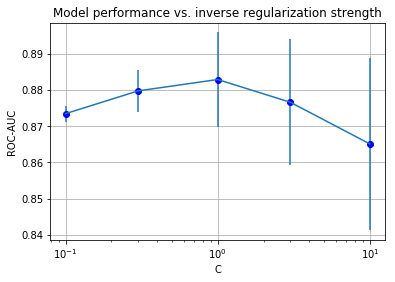

In [15]:
import matplotlib.pyplot as plt
plt.semilogx(params['C'], res['mean_test_score'], 'bo')
plt.errorbar(params['C'], res['mean_test_score'], yerr=res['std_test_score'])
plt.title('Model performance vs. inverse regularization strength')
plt.xlabel('C')
plt.ylabel('ROC-AUC')
plt.grid()
plt.show()

## Evaluate model

In [16]:
# Retrain best model on entire training set and predict outcomes on test set
from sklearn import metrics
clf_best = clf_cv.best_estimator_.fit(X_counts_train, y_train)
y_pred_test = clf_best.predict_proba(X_counts_test)[:,1]

Maximum F1 score: 0.5476190476190476
Precision at max: 0.575
Recall at max: 0.5227272727272727
Optimal threshold: 0.23191681680156015
Confusion matrix: 
 [[258  17]
 [ 22  22]]


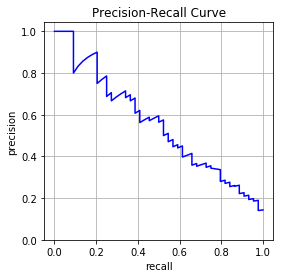

<Figure size 432x288 with 0 Axes>

In [17]:
# precision-recall analysis:
precision, recall, eps = metrics.precision_recall_curve(y_test, y_pred_test)
f1 = 2 * precision * recall / (precision + recall)
f1max_ind = np.argmax(f1)
print("Maximum F1 score: " + str(f1[f1max_ind]))
print("Precision at max: " + str(precision[f1max_ind]))
print("Recall at max: " + str(recall[f1max_ind]))
print("Optimal threshold: " + str(eps[f1max_ind]))

# confusion matrix at optimal threshold
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, y_pred_test>eps[f1max_ind]))

# precision recall curve
fig, ax = plt.subplots() 
ax.plot(recall, precision, 'b-')
ax.set(xlabel='recall', ylabel='precision',ylim=(0,None))
ax.set_aspect('equal')
ax.grid()
plt.title('Precision-Recall Curve')
plt.show()
plt.clf()

ROC-AUC:  0.8350413223140497


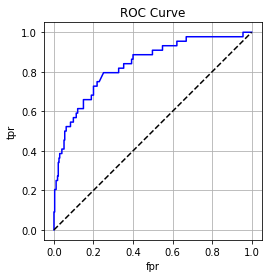

<Figure size 432x288 with 0 Axes>

In [18]:
# ROC Analysis:
fpr, tpr, th = metrics.roc_curve(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_test)
print("ROC-AUC: ", roc_auc)

fig, ax = plt.subplots() 
ax.plot(fpr, tpr, 'b-')
ax.plot([0,1],[0,1],'k--')
#ax.plot([0,0.5],[1,0.5], 'k-')
#ax.plot([0,0.3],[1,1],'k',linewidth=10)
#ax.plot([0],[1],'ro',markersize=20)
ax.set(xlabel='fpr', ylabel='tpr')
ax.set_aspect('equal')
ax.grid()
plt.title("ROC Curve")
plt.show()
plt.clf()

## What words are important?

In [19]:
# find coefficient size order from min to max
argsrt = np.argsort(clf_best.coef_).flatten()

In [20]:
# map to words
var=np.asarray(list(count_vect.vocabulary_.keys()))
sorted_words = var[argsrt] # error: too many indices for the array
sorted_words.shape

(609,)

In [21]:
argsrt.shape

(609,)

In [22]:
# top words predicting attack:
n=25
print("Attack words: ", sorted_words[-1:-1*n-1:-1])

# predicting not attack:
print("Non-attack words: ", sorted_words[0:n])

Attack words:  ['including' 'congress' 'protection' 'de' 'vets' 'served' 'place' 'farm'
 'choice' 'story' 'together' 'passing' 'friends' 'back' 'chairman' 'info'
 'people' '4th' '1st' 'great time' 'pass' 'office' 'dc' 'obama' 'right']
Non-attack words:  ['tune' 'hard' 'pm' 'friend' 'forward' 'men' 'rt' 'congressional'
 'infrastructure' 'food' 'latest' 'making' 'town hall' 'students' 'daca'
 'leadership' 'heres' 'make' 'programs' 'competition' 'health care'
 'deeply' 'costs' 'missed' 'district']


## What are examples where the model got it wrong?

In [23]:
# Predicted attack but wasn't:
idx=np.logical_and(y_pred_test>eps[f1max_ind], y_test!=1)
idx=idx[idx].index
list(df.loc[idx].text)

['Met with President Houshmand and toured @RowanUniversity. Amazing growth of campus and innovative approaches to addressing student costs and relevant degrees/certificate programs.pic.twitter.com/YA0wisf9va',
 'ICYMI yesterday, here are my remarks to the House and Senate Budget Conference Committeehttps://www.youtube.com/watch?v=Af12n75mPLw...',
 'The moment to act is now. #CBO Reports #Immigration Bill would reduce deficit by $197 billion over 10 years. http://www.cbo.gov/',
 "At the invitation of Bishop Su'a and Salote Schuster a few years ago I attended a General Conference in Salt Lake City where I was privileged to hear President Monson speak.https://radewagen.house.gov/media-center/press-releases/statement-honoring-life-thomas-s-monson...",
 '"We have ended the war on American Energy -- and we have ended the war on clean coal.  We are now an exporter of energy to the world." -@POTUS #SOTU',
 "Fixing our nation's broken immigration system shouldn't be a partisan issue. That's why

In [24]:
# Predicted non-attack but was:
idx=np.logical_and(y_pred_test<=eps[f1max_ind], y_test==1)
idx=idx[idx].index
list(df.loc[idx].text)

['About to join @hardball on @MSNBC to discuss Republicans refusal to face reality of @TheJusticeDept IG report, which found no evidence of bias in the investigation.https://twitter.com/hardball/status/1007393245163409408...',
 "The 20 week abortion ban signed by @GovWalker today is an attack on women's reproductive health: http://pocan.house.gov/media-center/press-releases/pocan-condemns-wisconsin-s-20-week-abortion-ban... #StopTheBans",
 'Another example of "spendulus" bill doing more harm than good http://tinyurl.com/oztxn6',
 "@RepPaulRyan Which is why you're including the revenues from the fiscal cliff deal in your budget? #RyanBudgetFail",
 'This court ruling is an important victory. The implementation of #Obamacare was illegal and its policies are harmful. http://thehill.com/policy/healthcare/253115-court-allows-boehner-lawsuit-against-obamacare-to-move-forward...',
 "Prayers for #NiceFrance\\xe2\\x80\\x94yet another wake-up call to challenges free world faces from jihad. It's t